# Restaurant Reviews Analysis on Yelp



In [31]:
# Import libraries
import requests
import json
import time
import pandas as pd
import numpy as np
import string
from collections import Counter

from bs4 import BeautifulSoup

import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

ModuleNotFoundError: No module named 'pyLDAvis'

## Data Scraping

Yelp has a pretty large dataset on restaurants throughout the United States. However, we are more interested at restaurants around us and want to get insights from reviews in those restaurants. Thus, here we retrieved around 1000 restaurants near Mountain View, CA 94043 from Yelp as our dataset.

We conducted a two-stage data scraping:

1. Retrieving restaurant list from Yelp API
2. Retrieving review list from web scraping

### Retrieving restaurant list from Yelp API

According to [Yelp API](https://www.yelp.com/developers/documentation/v3) documentation, we used endpoint of searching businesses to get restaurants list around certain location. 

Here we read [Yelp API Key](https://www.yelp.com/developers/v3/manage_app) from a local file named `api_key.txt` and provide functions to retrieve a restaurant list with location criteria.

In [ ]:
# Load API key from file 
with open('api_key.txt', 'r') as f:
    api_key = f.read().replace('\n','')

In [ ]:
def extract_info_for_business(row):
    return {'name': row['name'], 'id': row['id'], 'review_count': int(row['review_count']), 'url': row['url']}

def scrape_restaurant_list(api_key, location, max_num=1000):
    """ Retrieve a restaurant list based on location from Yelp API
        Args: 
            location(string): 
            max_num(integer): maximum number of restaurants to retrieve
        Returns:
            businesses_list(list): a restaurant list with name, id, review_count, url for each restaurant
    """   
    payload = {'categories': 'restaurants', 'location': location, 'limit': 20, 'offset': 0}
    basic_url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer ' + api_key}
    response = requests.get(basic_url, params=payload, headers=headers)
    res_json = response.json()
    total = res_json['total']
    businesses_list = list(map(extract_info_for_business, res_json['businesses']))
    while len(businesses_list) < total and len(businesses_list) < max_num:
        time.sleep(0.3)
        payload['offset'] = len(businesses_list)
        response = requests.get(basic_url, params=payload, headers=headers)
        res_json = response.json()
        if 'businesses' not in res_json or len(list(res_json['businesses'])) == 0:
            break
        businesses_list.extend(list(map(extract_info_for_business ,res_json['businesses'])))
    
    return businesses_list

For our project, we retrieved a list of 1000 restaurants for further analysis. As shown below, each of the restaurant in the list contains following information:

1. `name`: restaurant's name
2. `id`: restaurant's id
3. `review_count`: total number of reviews under that restaurant
4. `url`: url linked to the restaurant's page

In [ ]:
blist = scrape_restaurant_list(api_key, '94043')

print('Total:', len(blist))
# print('Total: 1000')
print(blist[0])
# print("{'name': \"The Sea by Alexander's Steakhouse\", 'id': 'P1eEPolk9EDGqVn1Jyncww', 'review_count': 874, 'url': 'https://www.yelp.com/biz/the-sea-by-alexanders-steakhouse-palo-alto?adjust_creative=6RD6nFOw75PxaCjeWnG24Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=6RD6nFOw75PxaCjeWnG24Q'}")

### Retrieving review list from web scraping

Yelp API also provides a way to retrieve reviews for a restaurant by its id. However, in practice, we found out the reviews sent back from API call are cut after a certain length. Thus, we scraped reviews manually from the web page. 

Here we provide a function to parse the reviews on a single page of a restaurant and store each review with its:

1. `review_id`: review id
2. `user_id`: user id
3. `rating`: rating from 1.0 to 5.0
4. `date`: date that the review is created
5. `text`: content of the review

In [ ]:
def parse_page(html):
    """ Parse the reviews on a single page of a restaurant.
        Args:
            html (string): String of HTML corresponding to a Yelp restaurant
        Returns:
            tuple(list, string): a tuple of two elements
                first element: list of dictionaries corresponding to the extracted review information
                second element: URL for the next page of reviews (or None if it is the last page)
    """
    review_list = []
    soup = BeautifulSoup(html, 'html.parser')
    for review_block in soup.find_all('div', attrs={'class': 'review review--with-sidebar'}):
        review_id = user_id = rating = date = text = None
        if 'data-review-id' in review_block.attrs:
            review_id = review_block['data-review-id']
        if 'data-signup-object' in review_block.attrs and review_block['data-signup-object'].startswith('user_id:'):
            user_id = review_block['data-signup-object'][8:]
        rating_div = review_block.find('div', attrs={'class': 'i-stars'})
        if 'title' in rating_div.attrs:
            rating = float(rating_div['title'].split()[0])
        date_span = review_block.find('span', attrs={'class': 'rating-qualifier'})
        if date_span:
            date = date_span.getText().strip()
        review_content = review_block.find('div', attrs={'class': 'review-content'})
        if review_content:
            text = review_content.find('p').getText()
        if review_id and user_id and rating and date and text:
            review_list.append({
                'review_id': review_id,
                'user_id': user_id,
                'rating': rating,
                'date': date,
                'text': text
            })
    next_link = None
    next_ele = soup.find('a', attrs={'class': 'u-decoration-none next pagination-links_anchor'})
    if next_ele and 'href' in next_ele.attrs:
        next_link = next_ele['href']
    return review_list, next_link

Here we provide another function to get all reviews from a restaurant list and store those data into `reviews.csv` for future use.

In [ ]:
def scrape_all_reviews(restaurants):
    """ Scrape all reviews from a restaurant list and store them into reviews.csv
        Args:
            restaurants(list): a restaurant list with url for each restaurant
    """
    for i, restaurant in enumerate(restaurants):
        reviews = []
        url = restaurant['url']
        while url != None:
            response = requests.get(url)
            reviews_in_page, url = parse_page(response.content)
            reviews.extend(reviews_in_page)
        df = pd.DataFrame(reviews)
        df.to_csv('reviews.csv', mode='a', header=True)

In [ ]:
scrape_all_reviews(blist)

In `reviews.csv`, each row represents a review with its id, user id, rating, date and text as stated before. Here is how our dataset looks like.

In [13]:
df = pd.read_csv(open('reviews.csv','r'))
df.head()

,Unnamed: 0,date,rating,review_id,text,user_id
0,0,4/30/2018,5.0,0Si_T9jAoYGhcQbdkMa8iQ,Had an amazing four course dinner here! 1. Wil...,eBXvTpaU4KPf2Busy_xEZA
1,1,4/4/2018,4.0,du-a3LYobeY7FBM3nF-3Jg,A Saturday date night with my boyfriend - and ...,a-F64OPbsaI3Ab1imMyLAw
2,2,4/2/2018,5.0,RKcin7_HV7ZmNUFn364DPg,Was able to get a seat at the bar at 1700 with...,YxX2NGb_gIhCn5c8ZbQL9w
3,3,4/15/2018,4.0,zFQnFy3il8b6NwCFva6Evg,Tasting menu here is delicious! Alexander's pa...,mcG523uA11CIk8OP4ieRGQ
4,4,3/1/2018,5.0,H2OJVI0ZEh2h5OHyYJGT_g,One of the best fine dining restaurants I've b...,NFo1WMzgrt_1Jv_DrdQzAw


In data scraping phase, we actually noticed something interesting from Yelp's data. We retrieved around 1000 restaurants from Yelp API, but when we were retrieving reviews from restaurants, we found that a large number of restaurants don't have reviews at all. From that restaurant list, only around 250 restaurants have reviews in it.

## Data Analysis

In data analysis phase, we dug into the dataset to find insights from reviews for restaurants near us. Here are 3 main parts in this section:

1. Data Preprocessing: extract useful information from raw data
2. General Observations: explore correlation between fields in dataset
3. Popolar Topics in Reviews: find out the most popular thing that customers care about in reviews

### Data Preprocessing

Here we processed our dataset by extracting only review rating and text, excluding missing data and adding a new field of review length.

In [41]:
def word_count(str):
    return len(str.split())

def pre_process(df):
    new_df = df
    # Extract reviews and ratings
    new_df = new_df[['text', 'rating']]
    
    # remove invalid rows with ",text,rating"
    new_df = new_df[new_df.rating.astype(str).str.contains("rating") == False]

    # convert rating values to float
    new_df['rating'] = new_df['rating'].astype(float).fillna(0)
    # add length column to record word count of reviews
    new_df['length'] = new_df['text'].astype(str).apply(word_count)
    return new_df

The dataframe after preprocessing can be seen as follows.

In [17]:
df = pre_process(df)
df.head()

133


,text,rating,length
0,Had an amazing four course dinner here! 1. Wil...,5.0,133
1,A Saturday date night with my boyfriend - and ...,4.0,112
2,Was able to get a seat at the bar at 1700 with...,5.0,57
3,Tasting menu here is delicious! Alexander's pa...,4.0,15
4,One of the best fine dining restaurants I've b...,5.0,233


### General Obeservations



### Popular topics in reviews



**Topic Modeling with LDA**

In [42]:
def text_process(text):
    """ Remove punctuations and stop words from text
        Args: 
            text(string)
        Returns:
            (list): list of words after processing
    """
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [43]:
def get_docs_for_rating(rating):
    """ Get all reviews under a certain rating
        Args:
            rating(integer)
        Returns:
            (list): review list with each of them a processed word list
    """
    raw_text_list = df[df.rating == rating].text.tolist()
    return [text_process(doc) for doc in raw_text_list]

In [20]:
low_rating = 1.0
low_docs = get_docs_for_rating(low_rating)

In [21]:
high_rating = 5.0
high_docs = get_docs_for_rating(high_rating)

In [ ]:
def lda_model(docs):
    """
        Generate LDA model for docs
        Args:
            docs(list): list of documents
        Returns:
            lda_model(LdaModel): LDA model generated by gensim
            dictionary(corpora.Dictionary): a mapping between words and their integer ids
            corpus(list of list): Bag of Word representation of documents 
    """
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(text) for text in docs]

    da_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return lda_model, dictionary, corpus

In [ ]:
low_lda_mode, low_dictionary, low_corpus = lda_model(low_docs)
pyLDAvis.display(pyLDAvis.gensim.prepare(low_lda_model, low_corpus, low_dictionary))

In [ ]:
high_lda_mode, high_dictionary, high_corpus = lda_model(high_docs)
pyLDAvis.display(pyLDAvis.gensim.prepare(high_lda_model, high_corpus, high_dictionary))

With topics generated from LDA algorithm, we summarized 5 topics from the outputs and extracted the meaningful keywords in those topics for both low rating reviews and high rating reviews.

Topics and keywords from low rating reviews are:

* Topic 1 **(Service)**: order table minutes wait
* Topic 2 **(Payment)**: bill tip charge card use credit pay cash
* Topic 3 **(Food)**: chicken meat rice sauce dish salad cheese soup bread
* Topic 4 **(Health)**: stomach burrito sick authentic lettuce
* Topic 5 **(Food, Environment)**: pizza sandwich crowded egg falafel pita

Topics and keywords from high rating reviews are:

* Topic 1 **(Service)**: get order wait people lunch good pretty
* Topic 2 **(Food)**: like ramon pork eat never soup
* Topic 3 **(Food)**: milk cafe burger meats see look
* Topic 4 **(Food)**: chicken rib falafel prime grill job wrap ribeye baked beers
* Topic 5 **(Environment)**: sandwich coffee awesome waiters environment quiet

As from those topics, we concluded that generally customers comment restaurants from 5 perspectives, which are Service, Payment, Food, Health and Environment. In those perspectives, Payment and Health are only mentioned in low rating reviews, from which we could infer that customers treat those 2 things as restaurants' baselines. Customers will complain about Payment method and Health when not satisfied, but will not give a 5-star rating without impression on other things like Service, Food and Environment.

**Word Cloud**

To further support our conclusion on customers' concerns, we used [word cloud](https://github.com/amueller/word_cloud) to visualize the most common words that customers mention in reviews.

Word cloud visualization includes the following steps:

1. Get word list for word cloud visualization
2. Get stop words to exclude
3. Generate a word cloud and show

Firstly, we flattened our previous `docs` to have two word list for low rating reviews and high rating reviews.

In [23]:
def flatten_docs(docs):
    return [word for doc in docs for word in doc]

low_rating_words = flatten_docs(low_docs)
high_rating_words = flatten_docs(high_docs)

In [24]:
print(low_rating_words[:10])

['Shame', 'Sea', 'supposed', 'high', 'class', 'restaurant', 'staffs', 'stole', 'money', 'wallet']


As our purpose was to generate word cloud for low and high rating reviews separately with comparison, and we had already removed stop words from the text, we defined the common words in top 20 frequent words in both reviews as the stop words sent to the word cloud generator.

In [28]:
def get_common_words(words1, words2, num=20):
    """ Get common words for two word list
        Args:
            words1(list)
            words2(list)
            num(integer): the number of top frequent words to compare
        Returns:
            common_words(list): the common words in top frequent words in both input list
    """
    counter1 = Counter(words1)
    counter2 = Counter(words2)
    freq_words1 = set([word[0] for word in counter1.most_common()[:num]])
    freq_words2 = set([word[0] for word in counter2.most_common()[:num]])
    common_words = list(freq_words1 & freq_words2)
    return common_words

common_words = get_common_words(low_rating_words, high_rating_words)
print('Common words: ', common_words)

Common words:  ['get', 'place', 'like', 'go', 'restaurant', 'time', 'back', 'good', 'one', 'food', 'service']


With the following two functions, we generated word cloud for both low rating reviews and high rating reviews.

In [29]:
def generate_word_cloud(words_list, stop_words=[], max_words=100):
    """ Generate a word cloud
        Args:
            words_list(list): list of word as the word cloud data
            stop_words(list): list of stop words to exclude
            max_words(integer): maximum number of word to show on the word cloud image
        Return:
            (WordCloud)
    """
    word_cloud = WordCloud(background_color='white',
                          stopwords=stop_words,
                          max_words=max_words,
                         ).generate(' '.join(words_list))
    return word_cloud

def show_word_cloud(word_cloud):
    """ Show a word cloud
        Args: 
            word_cloud(WordCloud)
    """
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

Word Cloud for low rating reviews:


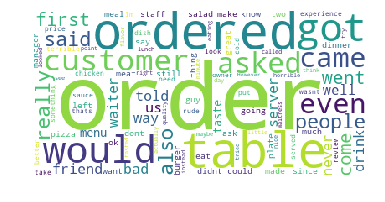

In [34]:
low_rating_word_cloud = generate_word_cloud(low_rating_words, stop_words=common_words)
print('Word Cloud for low rating reviews:')
show_word_cloud(low_rating_word_cloud)

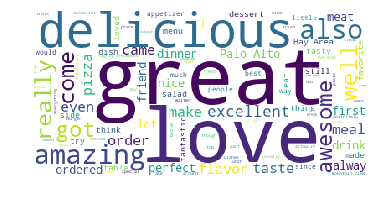

In [33]:
high_rating_word_cloud = generate_word_cloud(high_rating_words, stop_words=common_words)
print('Word Cloud for high rating reviews:')
show_word_cloud(high_rating_word_cloud)

As can be seen from the word clouds, in low rating reviews, customers mention 'order', 'asked', 'table' a lot, which points out their opinions on restaurants' service. While in high rating reviews, positive adjectives like 'delicious', 'great', 'amazing' occupy a lot of space. From those two word clouds, we could easily notice different emotions and attitudes.

Those two word clouds give some further support on our previous summarization from topic modeling. However, since positive adjectives like 'great' and 'amazing' are quite general, we can not conclude from those adjectives that customers mention which part of the restaurant in the review. Thus, we generate another word cloud which contains only nouns in the text.

Here we used the word tagging function in `nltk` library to extract only nouns from the word list.

In [36]:
def get_nouns_from_words(all_words):
    all_words_with_tag = nltk.pos_tag(all_words)
    return [word[0] for word in all_words_with_tag if word[1] == 'NN']

In [39]:
low_rating_nouns = get_nouns_from_words(low_rating_words)
high_rating_nouns = get_nouns_from_words(high_rating_words)

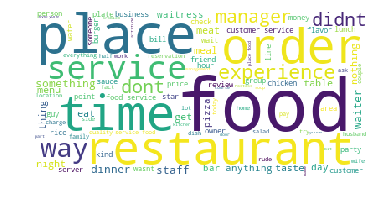

In [40]:
low_rating_nouns_word_cloud = generate_word_cloud(low_rating_nouns)
show_word_cloud(low_rating_nouns_word_cloud)

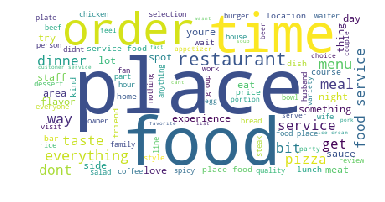

In [38]:
high_rating_nouns_word_cloud = generate_word_cloud(high_rating_nouns)
show_word_cloud(high_rating_nouns_word_cloud)

As can be seen from the noun cloud for low rating reviews, customers complain about 'food', 'order', 'place', 'time' and 'service'. In high rating reviews, customers mainly mention 'place', 'food', 'time' and 'order'. 

Recalling our previous conclusion on customers' concern, customers care about Service, Payment, Food, Health and Environment. We treated 'place' in the word cloud as a representative of Environment, and the results from word cloud match well with the conclusion from topic modeling. For a 5-star rating, Food and Environment are a must. To avoid a 1-star rating, restaurants should take care of their basic services.

### Insights